In [241]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision

import seaborn as sns
from tqdm.notebook import tqdm

from torchvision.ops import batched_nms
import mmcv

from ensemble_boxes import *

from matplotlib.pyplot import imshow
from PIL import Image

In [242]:
def plot_image(img_path, boxes, labels, scores,  score_thr=0.0):
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    image = image.astype('float32')
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
        { 'id':14, 'name': 'No finding'},
    ] 
    
    plt.figure(figsize=(16,16))
    
    for box, label, score in zip(boxes, labels, scores):
        
        if score < score_thr:
            continue
        
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (225,0,0), 4)
        label = categories[label]['name'].upper() + " " + str(score)
        print(label, box)
        cv2.putText(image, 
                    label,
                    (box[0], box[1]), 
                    fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                    fontScale = 1,
                    color = (255, 0, 0),
                    thickness = 2,
                    lineType = cv2.LINE_AA
                   )
    plt.imshow(image)

In [275]:
import pickle
from ensemble_boxes import *

folds = range(5)
fold_preds = []

for i in folds:

    with open(f'./tests/test_fold_{i}_higher_thr.pkl', 'rb') as f:
        fold_preds.append(pickle.load(f))
    
test_df = pd.read_csv('test.csv')

test_healthy = pd.read_csv('test_healthy.csv')
test_healthy = test_healthy.set_index('image_id')

submission_vals = []

# score_thr = 0.1

nms_thr = 0.5
wbf_thr = 0.4

low_thr = 0.0
high_thr = 0.99

freq_df = []

box_counts = []

for _id in tqdm(range(len(test_df))):

    r = test_df.iloc[_id]

    image_id = r['image_id']

    health_score = test_healthy.loc[image_id]['label']

    width = r['width']
    height = r['height']
    
    boxes = []
    scores = []
    labels = []
    
    if health_score > high_thr:
        pred_str = f'14 {round(health_score, 3)} 0 0 1 1'
      
        submission_vals.append([image_id, pred_str])

        continue
    
    for fold_id in range(len(folds)):
        
        preds = fold_preds[fold_id][_id]
        
        fold_boxes = []
        fold_scores = []
        fold_labels = []

        for i, pred in enumerate(preds):
            if len(pred):
                for p in pred:
                    
                    score = p[4].astype(float)
                    
                    box = p[:4]

                    box[0] = box[0] / (width)
                    box[2] = box[2] / (width)
                    box[1] = box[1] / (height)
                    box[3] = box[3] / (height)
                    
                    box = np.clip(box, 0.0, 1.0)
                    fold_boxes.append(box)
                    fold_scores.append(score)
                    fold_labels.append(i)

#         fold_boxes, fold_scores, fold_labels = nms([fold_boxes], [fold_scores], [fold_labels], iou_thr=nms_thr)
        
        boxes.append(fold_boxes)
        scores.append(fold_scores)
        labels.append(fold_labels)
        
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, iou_thr=wbf_thr)
            
    boxes[:, 0] = boxes[:, 0]*width
    boxes[:, 2] = boxes[:, 2]*width
    boxes[:, 1] = boxes[:, 1]*height
    boxes[:, 3] = boxes[:, 3]*height
    
    boxes = boxes.astype(int)
    labels = labels.astype(int)

    _id_preds = []
    
    box_counts.append(len(boxes))
    
    for i in range(len(boxes)):
        _id_preds.append(str(labels[i]))
        _id_preds.append(str(scores[i].round(2)))
        _id_preds.append(str(boxes[i][0]))
        _id_preds.append(str(boxes[i][1]))
        _id_preds.append(str(boxes[i][2]))
        _id_preds.append(str(boxes[i][3]))

    pred_str = " ".join(_id_preds)
        
    if low_thr < health_score < high_thr:
        pred_str += f' 14 {round(health_score, 3)} 0 0 1 1'
        freq_df.append(dict(
                class_id=14,
                image_id=image_id
            ))
    submission_vals.append([image_id, pred_str])
    
print(np.mean(box_counts))
df = pd.DataFrame(submission_vals, columns = ['image_id','PredictionString'])

  0%|          | 0/3000 [00:00<?, ?it/s]

53.4871395167576


In [276]:
len(df[df['PredictionString'] == '14 1.0 0 0 1 1'])

1235

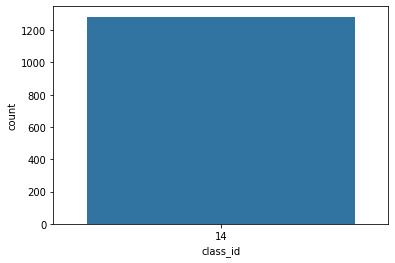

In [277]:
freq_df = pd.DataFrame(freq_df)

ax = sns.countplot(x="class_id",data=freq_df)

In [278]:
df.to_csv("submission.csv",index=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


83caa8a85e03606cf57e49147d7ac569
CARDIOMEGALY 0.85 [ 812 1149 1766 1516]
AORTIC ENLARGEMENT 0.22 [1076  738 1328  969]
PLEURAL THICKENING 0.18 [1384  457 1635  605]
PLEURAL THICKENING 0.16 [1221  457 1524  542]
PLEURAL THICKENING 0.15 [ 143 1512  231 1642]
PLEURAL EFFUSION 0.14 [ 142 1512  231 1641]
PLEURAL EFFUSION 0.13 [1685 1189 1877 1522]
LUNG OPACITY 0.13 [638 406 983 691]
PLEURAL THICKENING 0.11 [588 426 780 545]
PLEURAL THICKENING 0.1 [1721 1208 1872 1500]
PLEURAL THICKENING 0.1 [1219  434 1637  613]
PLEURAL THICKENING 0.1 [620 407 964 536]
PLEURAL THICKENING 0.1 [550 403 969 647]
ILD 0.09 [ 221  765  855 1470]
NODULE/MASS 0.07 [ 656 1153  808 1314]
LUNG OPACITY 0.07 [ 253 1252  727 1485]
LUNG OPACITY 0.06 [1529  630 1793 1106]
AORTIC ENLARGEMENT 0.06 [ 896  735 1335 1052]
PLEURAL EFFUSION 0.05 [1373 1134 1916 1795]
LUNG OPACITY 0.05 [ 655 1152  807 1314]
OTHER LESION 0.04 [ 246 1263  777 1507]
OTHER LESION 0.04 [ 120 1281  927 2003]
PLEURAL THICKENING 0.04 [1200  466 1349  551]

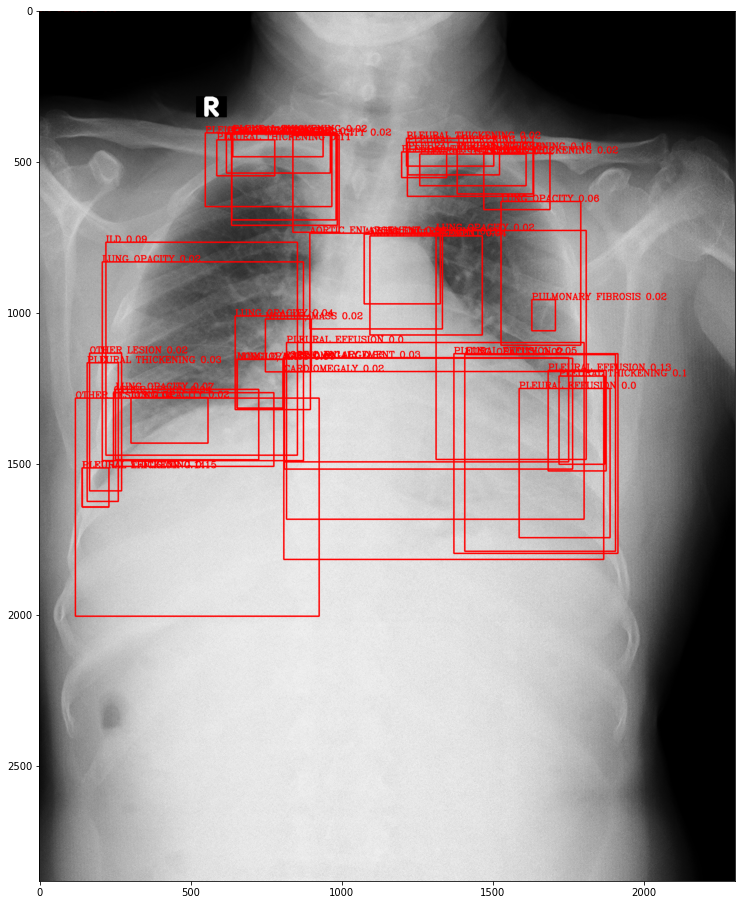

In [335]:
sub = pd.read_csv('submission.csv')
# sub_244 = pd.read_csv('submission_244.csv').set_index('image_id')
# sub_244 = sub_244.reindex(index=sub['image_id']).reset_index()
# sub_244.to_csv('submission_244_reindexed.csv', index=False)

row = sub.iloc[1 - 1]
pred_string = row['PredictionString']
image_id = row['image_id']
print(image_id)
img_path = 'vinbigdata/images/test/' + image_id + '.jpg'

pred = np.array(list(map(lambda x: float(x), pred_string.split(' '))))
pred = pred.reshape(-1,6)

boxes = pred[:, 2:].astype(int) 
scores = pred[:,1].astype(float)
labels = pred[:,0].astype(int)

plot_image(img_path, boxes, labels, scores, score_thr=0)

In [336]:
import pickle
from ensemble_boxes import *

folds = range(5)
fold_preds = []

for i in folds:

    with open(f'./tests/test_fold_{i}.pkl', 'rb') as f:
        fold_preds.append(pickle.load(f))
    
test_df = pd.read_csv('test.csv')

test_healthy = pd.read_csv('test_healthy.csv')
test_healthy = test_healthy.set_index('image_id')

submission_vals = []

nms_thr = 0.5
wbf_thr = 0.6

low_thr = 0.0
high_thr = 0.99

freq_df = []

box_counts = []

sub = pd.read_csv('submission_244_reindexed.csv')

for _id in tqdm(range(len(test_df))):

    r = test_df.iloc[_id]

    image_id = r['image_id']

    health_score = test_healthy.loc[image_id]['label']

    width = r['width']
    height = r['height']
    
    boxes = []
    scores = []
    labels = []
    
    if health_score > high_thr:
        pred_str = f'14 {round(health_score, 3)} 0 0 1 1'
      
        submission_vals.append([image_id, pred_str])

        continue
    
    for fold_id in range(len(folds)):
        
        preds = fold_preds[fold_id][_id]
        
        fold_boxes = []
        fold_scores = []
        fold_labels = []

        for i, pred in enumerate(preds):
            if len(pred):
                for p in pred:
                    
                    score = p[4].astype(float)
                    
#                     if score < 0.1:
#                         continue
                    
                    box = p[:4]

                    box[0] = box[0] / (width)
                    box[2] = box[2] / (width)
                    box[1] = box[1] / (height)
                    box[3] = box[3] / (height)
                    
                    box = np.clip(box, 0.0, 1.0)
                    fold_boxes.append(box)
                    fold_scores.append(score)
                    fold_labels.append(i)
        
        if len(fold_boxes) == 0:
            continue
        
        fold_boxes, fold_scores, fold_labels = nms([fold_boxes], [fold_scores], [fold_labels], iou_thr=nms_thr)
        
        boxes.append(fold_boxes)
        scores.append(fold_scores)
        labels.append(fold_labels)
        
    
    row = sub.iloc[_id]
    pred_string = row['PredictionString']
    img_path = 'vinbigdata/images/test/' + image_id + '.jpg'

    pred = np.array(list(map(lambda x: float(x), pred_string.split(' '))))
    pred = pred.reshape(-1,6)

    boxes_244 = pred[:, 2:]
    scores_244 = pred[:,1].astype(float)
    labels_244 = pred[:,0].astype(int)
        
    if low_thr < health_score < high_thr:
        np.concatenate([boxes_244, np.array([[0,0,1,1]])])
        np.concatenate([scores_244, np.array([health_score])])
        np.concatenate([labels_244, np.array([14])])
    
    boxes_244[:, 0] = boxes_244[:, 0] / width
    boxes_244[:, 2] = boxes_244[:, 2] / width
    boxes_244[:, 1] = boxes_244[:, 1] / height
    boxes_244[:, 3] = boxes_244[:, 3] / height
    
    boxes.append(boxes_244)
    scores.append(scores_244)
    labels.append(labels_244)

    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, iou_thr=wbf_thr)
            
    boxes[:, 0] = boxes[:, 0]*width
    boxes[:, 2] = boxes[:, 2]*width
    boxes[:, 1] = boxes[:, 1]*height
    boxes[:, 3] = boxes[:, 3]*height
    
    boxes = boxes.astype(int)
    labels = labels.astype(int)

    _id_preds = []
    
    box_counts.append(len(boxes))
    
    for i in range(len(boxes)):
        _id_preds.append(str(labels[i]))
        _id_preds.append(str(scores[i].round(2)))
        _id_preds.append(str(boxes[i][0]))
        _id_preds.append(str(boxes[i][1]))
        _id_preds.append(str(boxes[i][2]))
        _id_preds.append(str(boxes[i][3]))

    pred_str = " ".join(_id_preds)
        
    submission_vals.append([image_id, pred_str])
    
print(np.mean(box_counts))
df = pd.DataFrame(submission_vals, columns = ['image_id','PredictionString'])

  0%|          | 0/3000 [00:00<?, ?it/s]

133.84333593141076


In [337]:
df.to_csv("submission.csv",index=False)